<a href="https://colab.research.google.com/github/DeF0017/Face-Recognition-using-Siamese-Network/blob/main/Face_Recognition_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Standard Dependencies

In [ ]:
import uuid

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

Importing Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Layer, Input, Flatten
import tensorflow as tf

Setup Paths

In [ ]:
POS_PATH = os.path.join('Data','Positives')
NEG_PATH = os.path.join('Data', 'Negatives')
ANCHOR_PATH = os.path.join('Data', 'Anchor')

Making the Directories

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANCHOR_PATH)

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    old_path = os.path.join('lfw', directory, file)
    new_path = os.path.join(NEG_PATH, file)
    os.replace(old_path, new_path)

Collecting the images for positives and anchors

In [ ]:
vidcap = cv2.VideoCapture(0)
while vidcap.isOpened():
  ret, frame = vidcap.read()
  frame = frame[120:120+250,200:200+250,:]
  if cv2.waitKey(1) & 0XFF==ord('a'):
    imgname = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
  if cv2.waitKey(1) & 0XFF==ord('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
  cv2.imshow("Image Collection", frame)
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break
vidcap.release()
cv2.destroyAllWindows()

In [ ]:
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

**Preprocessing and Scaling the Data**

In [ ]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (105,105))
  img = img/255.0
  return img

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
def preprocess_twin(input_img, val_img, label):
  return(preprocess(input_img), preprocess(val_img), label)

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data =train_data.prefetch(8)

In [ ]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def embedding_layer():
  inp = Input(shape=(105,105,3), name="input_layer")
  c1 = Conv2D(64, (10,10), activation="relu", name="conv1")(inp)
  mp1 = MaxPooling2D(64, (2,2), padding="same", name="maxpool1")(c1)
  c2 = Conv2D(128, (7,7), activation="relu", name="conv2")(mp1)
  mp2 = MaxPooling2D(64, (2,2), padding="same", name="maxpool2")(c2)
  c3 = Conv2D(128, (4,4), activation="relu", name="conv3")(mp2)
  mp3 = MaxPooling2D(64, (2,2), padding="same", name="maxpool3")(c3)
  c4 = Conv2D(256, (4,4), activation="relu", name="conv4")(mp3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation="sigmoid")(f1)

  return Model(inputs=[inp], outputs=[d1], name="embedding")

In [ ]:
model = embedding_layer()

In [ ]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 64)        19264     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 48, 48, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 42, 42, 128)       401536    
                                                                 
 maxpool2 (MaxPooling2D)     (None, 21, 21, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 18, 18, 128)       262272    
                                                                 
 maxpool3 (MaxPooling2D)     (None, 9, 9, 128)         0 

In [ ]:
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding-validation_embedding)

In [ ]:
def siamese_model():
  input_img = Input(name="Input_Image", shape=(105,105,3))
  val_img = Input(name="Validation_Image", shape=(105,105,3))

  siamese_layer = L1Dist()
  siamese_layer._name="Distance"
  dist = siamese_layer(model(input_img), model(val_img))

  result = Dense(1, activation="sigmoid", name="classifier")(dist)

  return Model(inputs=[input_img, val_img], outputs=result, name="Siamese_Model")

In [ ]:
S_model = siamese_model()

In [ ]:
S_model.summary()

Model: "Siamese_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Image (InputLayer)    [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 Validation_Image (InputLay  [(None, 105, 105, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['Input_Image[0][0]',         
                                                          8          'Validation_Image[0][0]']    
                                                                                      

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, S_model=S_model)

In [ ]:
@tf.function
def train_step(batch):
  loss=0
  # Record all of our operations
  with tf.GradientTape() as tape:
    # Get anchor and positive/negative image
    X = batch[:2]
    # Get label
    y = batch[2]
    # Forward pass
    yhat = S_model(X, training=True)
    # Calculate loss
    loss += binary_cross_loss(y, yhat)
  # Calculate gradients
  grad = tape.gradient(loss, S_model.trainable_variables)

  # Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, S_model.trainable_variables))

  # Return loss
  return loss

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
  # Loop through epochs
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))
    # Creating a metric object
    r = Recall()
    p = Precision()
    loss = 0
    # Loop through each batch
    for idx, batch in enumerate(data):
      # Run train step here
      loss += train_step(batch)
      yhat = S_model.predict(batch[:2])
      r.update_state(batch[2], yhat)
      p.update_state(batch[2], yhat)
      progbar.update(idx+1)
    print(loss.numpy(),r.result().numpy(), p.result().numpy())

    # Save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
train(train_data, 7)


 Epoch 1/7
27/27 [==============================] - 732s 27s/step
12.927192 0.37320575 0.98734176

 Epoch 2/7
27/27 [==============================] - 817s 30s/step
3.916812 0.9677419 0.99526066

 Epoch 3/7
27/27 [==============================] - 819s 30s/step
0.8824686 1.0 1.0

 Epoch 4/7
27/27 [==============================] - 801s 29s/step
0.24984848 1.0 1.0

 Epoch 5/7
27/27 [==============================] - 783s 29s/step
0.16279343 1.0 1.0

 Epoch 6/7
27/27 [==============================] - 827s 31s/step
0.01793971 1.0 1.0

 Epoch 7/7
27/27 [==============================] - 876s 32s/step
0.010459539 1.0 1.0


In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = S_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


In [ ]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1]

In [ ]:
y_true

array([0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [ ]:
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = S_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 764ms/step
1.0 1.0


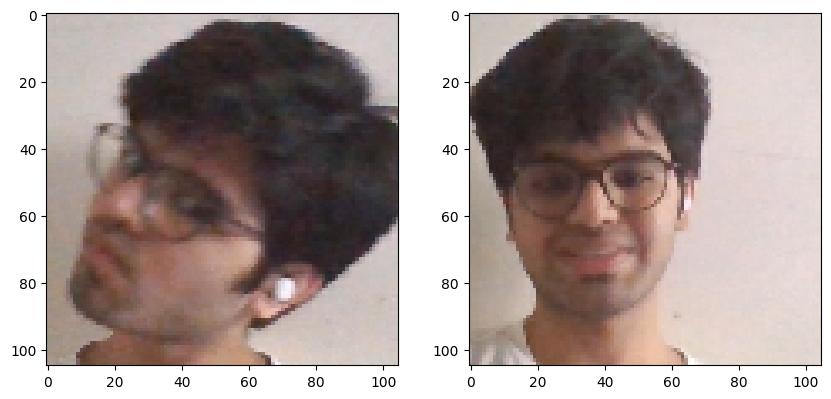

1.0


In [ ]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()
print(y_true[2])

In [ ]:
S_model.save('siamesemodelv2.h5')

C:\Users\drake\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10

#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(S_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 367ms/step
True
1/1 [==============================] - 0s 333ms/step
True
1/1 [==============================] - 0s 337ms/step
False
